<a href="https://colab.research.google.com/github/grenetercordovesdelgado/Ejercicios/blob/main/inertial_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification of Human Activities** 
[*Greneter Cordoves Delgado*](mailto:greneter@cicese.edu.com)

# Install libraries

In [64]:
!pip install hrv-analysis
!pip install pyhrv
!pip install tsfel
!pip or !apt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "or"


# Importing libraries and packages 

In [65]:
from google.colab import drive

import os
import sys
import cv2
from glob import glob
import glob
from tqdm.notebook import tqdm_notebook
import pandas as pd
import numpy as np
from joblib import dump
from skimage import io
import tsfel

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Patch

import seaborn as sns
from IPython.display import Image

import pyhrv.time_domain as td
import hrvanalysis
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_geometrical_features
from hrvanalysis import get_frequency_domain_features
from hrvanalysis import get_csi_cvi_features
from hrvanalysis import get_poincare_plot_features
from hrvanalysis import get_sampen

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import VarianceThreshold

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Loading training data 

In [66]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# Loading train CSV files 
csv_files = [os.path.abspath(x) for x in glob.glob('/content/drive/MyDrive/datos inerciales/train/*.csv')]

file_label = []
file_path = []

activities = {'MW': 'Walking', 
              'MR': 'Running', 
              'MJ': 'Jumping',
              'WD': 'Walking down the stairs',
              'WU': 'Walking up the stairs',
              'FF': 'Forward fall',
              'FS': 'Sideways fall',
              'FB': 'Backward fall',
              'LD': 'Lying down',
              'OT': 'Other'}

# Paths and labels to the files found
for path in tqdm_notebook(csv_files):
    part = os.path.basename(path)
    part = part.split('.')[0]       
    label = part.split('_')[2]
    file_label.append(activities[label])
    file_path.append(path)  

# Creating dataframe
label_df = pd.DataFrame(file_label, columns=['Label'])
path_df = pd.DataFrame(file_path, columns=['Path'])
dataset_df = pd.concat([label_df, path_df], axis = 1) 

  0%|          | 0/156 [00:00<?, ?it/s]

# Data Exploration

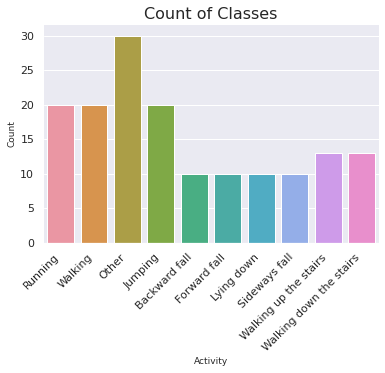

In [81]:
count_label = dataset_df.groupby('Label').count().reset_index()
label = np.array(count_label['Label'])

dataPath = pd.concat([dataset_df], axis = 0)
plt.title('Count of Classes', size=16)
sns.set_theme(palette="blend:#7AB,#EDA")
sns.countplot(x=dataPath["Label"])
plt.xlabel('Activity', size=9)
plt.ylabel('Count', size=9)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=45, ha='right')

plt.show()

# Data processing

### Feature Extraction

In [82]:
#Get feature vector

df_features = pd.DataFrame()

for path, label in zip(tqdm_notebook(dataset_df.Path), dataset_df.Label): 
    # columns name
    column_names = ['x', 'y', 'z', 'time']

    # Loading csv data
    df = pd.read_csv(path, names=column_names)

    # xy signal
    df['xy'] = df['x'] * df['y']

    # xz signal
    df['xz'] = df['x'] * df['z']

    # yz signal
    df['yz'] = df['y'] * df['z']

    # Acc signal
    df['total_acc'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

    gfd = tsfel.get_features_by_domain() 
            
    df = np.array(df)
    df = df[~np.isnan(df)] 

    features = tsfel.time_series_features_extractor(gfd, df, fs=2500, windows_size=500, overlap=0.2, verbose=False)

    f_df = pd.DataFrame(features, columns=features.columns)
    f_df['Label'] = label

    df_features = pd.concat([df_features, f_df], axis=0)

print("Number of instances:", df_features.shape[0])
print("Number of features:", df_features.shape[1]-1)

  0%|          | 0/156 [00:00<?, ?it/s]

Number of instances: 156
Number of features: 389


### Feature Selection

In [85]:
X = df_features.iloc[:, :-1]
X = X.apply(pd.to_numeric, errors='coerce')
Y = df_features.iloc[:, df_features.shape[1]-1]

# Highly correlated features are removed
corr_features = tsfel.correlated_features(X)
X.drop(corr_features, axis=1, inplace=True)

# Remove low variance features

#Create a feature selector object
selector = VarianceThreshold()

#Fit the selector to the data
selector.fit(X)

# Get a list of booleans indicating which columns have been selected
mask = selector.get_support()

# Select the columns of the original DataFrame that have been selected
X = X.loc[:, mask]

print(X.shape)

(156, 131)


### Normalising Features

In [86]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Clasification Model

## Splitting data

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

## Models

### Decision Tree Classifier

#### Initialize model, Training and Predicting

In [89]:
# Initialize model
model_dt = DecisionTreeClassifier()

# Training model
model_dt.fit(X_train, Y_train)

# Predicting for the test set
Y_pred_dt = model_dt.predict(X_test)

#### Confusion matrix and metrics

                         precision    recall  f1-score   support

          Backward fall       0.00      0.00      0.00         3
           Forward fall       0.33      0.33      0.33         3
                Jumping       1.00      0.83      0.91         6
             Lying down       0.43      1.00      0.60         3
                  Other       1.00      0.78      0.88         9
                Running       0.86      1.00      0.92         6
          Sideways fall       0.33      0.33      0.33         3
                Walking       0.80      0.67      0.73         6
Walking down the stairs       1.00      0.75      0.86         4
  Walking up the stairs       0.60      0.75      0.67         4

               accuracy                           0.70        47
              macro avg       0.64      0.64      0.62        47
           weighted avg       0.74      0.70      0.70        47



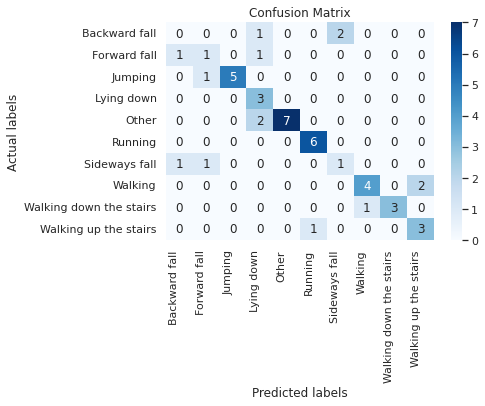

In [90]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, Y_pred_dt)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_label.Label)
ax.yaxis.set_ticklabels(count_label.Label, rotation=0, ha='right');
plt.xticks(rotation=90, ha='right')

# metrics
print(classification_report(Y_test, Y_pred_dt))

### Naive Bayes Classifier

#### Initialize model, Training and Predicting

In [91]:
# Initialize model
model_nb = GaussianNB()

# Training model
model_nb.fit(X_train, Y_train)

# Predicting for the test set
Y_pred_nv = model_nb.predict(X_test)

#### Confusion matrix and metrics

                         precision    recall  f1-score   support

          Backward fall       1.00      0.33      0.50         3
           Forward fall       0.67      0.67      0.67         3
                Jumping       1.00      0.67      0.80         6
             Lying down       1.00      0.67      0.80         3
                  Other       0.90      1.00      0.95         9
                Running       0.60      1.00      0.75         6
          Sideways fall       0.25      0.33      0.29         3
                Walking       0.86      1.00      0.92         6
Walking down the stairs       1.00      0.75      0.86         4
  Walking up the stairs       1.00      0.75      0.86         4

               accuracy                           0.79        47
              macro avg       0.83      0.72      0.74        47
           weighted avg       0.84      0.79      0.79        47



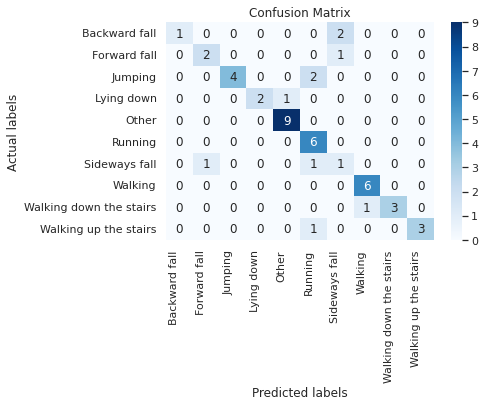

In [92]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, Y_pred_nv)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_label.Label)
ax.yaxis.set_ticklabels(count_label.Label, rotation=0, ha='right');
plt.xticks(rotation=90, ha='right')

# metrics
print(classification_report(Y_test, Y_pred_nv))

### Support Vector Machines (SVM)

#### Initialize model, Training and Predicting

In [93]:
# Initialize model
model_svc = SVC(kernel='linear')

# Training model
model_svc.fit(X_train, Y_train)

# Predicting for the test set
Y_pred_svm = model_svc.predict(X_test)

#### Confusion matrix and metrics

                         precision    recall  f1-score   support

          Backward fall       1.00      0.67      0.80         3
           Forward fall       0.75      1.00      0.86         3
                Jumping       1.00      1.00      1.00         6
             Lying down       0.75      1.00      0.86         3
                  Other       1.00      0.89      0.94         9
                Running       1.00      1.00      1.00         6
          Sideways fall       1.00      1.00      1.00         3
                Walking       1.00      1.00      1.00         6
Walking down the stairs       1.00      1.00      1.00         4
  Walking up the stairs       1.00      1.00      1.00         4

               accuracy                           0.96        47
              macro avg       0.95      0.96      0.95        47
           weighted avg       0.97      0.96      0.96        47



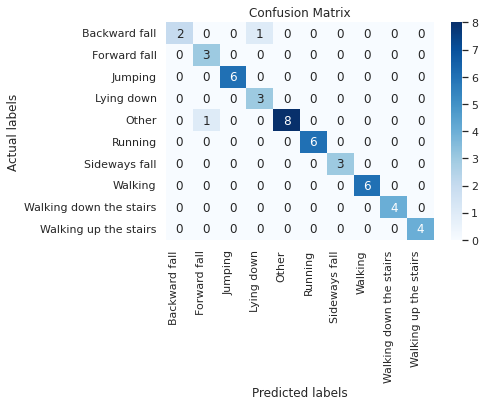

In [94]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, Y_pred_svm)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_label.Label)
ax.yaxis.set_ticklabels(count_label.Label, rotation=0, ha='right');
plt.xticks(rotation=90, ha='right')

# metrics
print(classification_report(Y_test, Y_pred_svm))

## Re-training the model

In [95]:
# Initialize the model
model_svc = SVC(kernel='linear')

# Re-training the model
X_svc = scaler.fit_transform(X)
Y_svc = Y
model_svc.fit(X_svc,Y_svc)

SVC(kernel='linear')

In [96]:
#Saving the model
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "/content/drive/MyDrive/datos inerciales/Human_Activities_Classifier.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_svc, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Human_Activities_Classifier = pickle.load(file)
Human_Activities_Classifier

SVC(kernel='linear')

# External validation

## Loading training data 

In [105]:
# Loading CSV files 
csv_files = [os.path.abspath(x) for x in glob.glob('/content/drive/MyDrive/datos inerciales/test/*.csv')]
csv_files = sorted(csv_files, key=lambda x: int(''.join(filter(str.isdigit, x))))

file_name = []
file_path = []

# Paths and labels to the files found
for path in tqdm_notebook(csv_files):
    part = os.path.basename(path)
    name = part.split('.')[0]       
    file_name.append(name)
    file_path.append(path)  

# Creating dataframe
file_name_df = pd.DataFrame(file_name, columns=['File_Name'])
path_df = pd.DataFrame(file_path, columns=['Path'])
dataset_df = pd.concat([path_df], axis = 1) 

  0%|          | 0/35 [00:00<?, ?it/s]

In [99]:
dataset_df.shape

(35, 1)

## Get feature vector

In [106]:
#Get feature vector

df_features = pd.DataFrame()

for path in tqdm_notebook(dataset_df.Path): 
    # columns name
    column_names = ['x', 'y', 'z', 'time']

    # Loading csv data
    df = pd.read_csv(path, names=column_names, delimiter=',',skiprows=2, skipinitialspace=True)

    # xy signal
    df['xy'] = df['x'] * df['y']

    # xz signal
    df['xz'] = df['x'] * df['z']

    # yz signal
    df['yz'] = df['y'] * df['z']

    # Acc signal
    df['total_acc'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

    gfd = tsfel.get_features_by_domain()

    df = np.array(df)
    df = df[~np.isnan(df)] 

    features = tsfel.time_series_features_extractor(gfd, df, fs=2500, windows_size=500, overlap=0.2, verbose=False)

    df_features = pd.concat([df_features, pd.DataFrame(features)], axis=0)

print("Number of instances:", df_features.shape[0])
print("Number of features:", df_features.shape[1]-1)

  0%|          | 0/35 [00:00<?, ?it/s]

Number of instances: 35
Number of features: 388


## Normalize data

In [107]:
X = df_features.iloc[:, :]
X = X.apply(pd.to_numeric, errors='coerce')
X.drop(corr_features, axis=1, inplace=True)

# Select the columns of the original DataFrame that have been selected
X = X.loc[:, mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Evaluating model 

In [111]:
activities = {'Walking': '1', 
              'Running': '2', 
              'Jumping': '3',
              'Walking down the stairs': '4',
              'Walking up the stairs': '5',
              'Forward fall': '6',
              'Sideways fall': '7',
              'Backward fall': '8',
              'Lying down': '9',
              'Other': '10'}

# Prediction
prediction = Human_Activities_Classifier.predict(X)

# Creating dataframe
pred_df = pd.DataFrame(prediction, columns=['Prediction'])
prediction_df = pd.concat([file_name_df, pred_df], axis = 1) 
print('Human Activities Classifier prediction:\n\n', prediction_df)

# Exporting a to txt file
# clean output_full.txt
with open('/content/drive/MyDrive/datos inerciales/output_full.txt', 'w') as f:
    pass

# fill output.txt
for index, row in prediction_df.iterrows():
  File_Name = row['File_Name']
  Prediction = row['Prediction']
  with open('/content/drive/MyDrive/datos inerciales/output_full.txt', 'a') as f:
    f.write(str(File_Name) + ' ' + str(Prediction))
    f.write("\n")

Human Activities Classifier prediction:

    File_Name             Prediction
0     file_0  Walking up the stairs
1     file_1                Jumping
2     file_2                Jumping
3     file_3  Walking up the stairs
4     file_4                Jumping
5     file_5  Walking up the stairs
6     file_6                Jumping
7     file_7                  Other
8     file_8           Forward fall
9     file_9                  Other
10   file_10  Walking up the stairs
11   file_11                Jumping
12   file_12                Walking
13   file_13                Jumping
14   file_14                Jumping
15   file_15             Lying down
16   file_16                Jumping
17   file_17                Jumping
18   file_18                Running
19   file_19                  Other
20   file_20                Jumping
21   file_21                Jumping
22   file_22                Walking
23   file_23             Lying down
24   file_24             Lying down
25   file_25          

#### Exporting predictions to txt file

In [112]:
# Exporting predictions
output = []
for out in prediction:
  output.append(activities[out])
output

# clean output.txt
with open('/content/drive/MyDrive/datos inerciales/output.txt', 'w') as f:
    pass

# fill output.txt
for out in output:
  with open('/content/drive/MyDrive/datos inerciales/output.txt', 'a') as f:
    f.write(str(out))
    f.write("\n")   